# Loop Detection
## Of long (>1 minute) Samples

In [1]:
import os
import pretty_midi
from midi_player import MIDIPlayer
from midi_player.stylers import dark

midi_file = os.path.join("data", "inputs", "MIDI1.mid")
midi_data = pretty_midi.PrettyMIDI(midi_file)
piano_roll = midi_data.get_piano_roll()

notes = []
for instrument in midi_data.instruments:
    # Don't include drum instruments
    if not instrument.is_drum:
        for note in instrument.notes:
            notes.append(
                pretty_midi.Note(note.velocity, note.pitch, note.start, note.end)
            )

MIDIPlayer(midi_file, 400, styler=dark)

## Chroma SSM

In [2]:
import ssm_utils
import numpy as np

sr = 2

chroma = midi_data.get_chroma(sr)
ssm_chroma = np.dot(np.transpose(chroma), chroma)
novelty_curve = ssm_utils.compute_novelty_ssm(ssm_chroma, L=1, exclude=True)
boundary = ssm_utils.get_boundaries(novelty_curve, np.array(range(0, chroma.shape[1])))

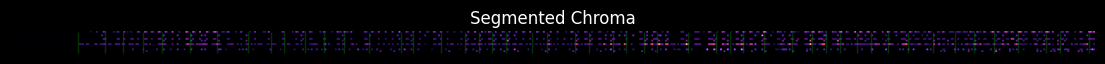

In [3]:
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(14, 10))
plt.imshow(chroma / chroma.max(), cmap="magma")
plt.vlines(boundary[1], 0, 12, "g", linewidth=1, alpha=0.4)
# plt.plot(
#     (1 - novelty_curve / novelty_curve.max()) * ssm_pr.shape[0],
#     "g",
#     linewidth=1,
#     alpha=0.4,
# )
plt.title("Segmented Chroma")
plt.axis("off")
plt.show()

## Segment the MIDI

In [8]:
segmented_midi = ssm_utils.boundary_split_t(notes, boundary[0] / sr)
segmented_midi

{0: [],
 19: [Note(start=20.489583, end=21.046875, pitch=31, velocity=40),
  Note(start=21.041667, end=21.218750, pitch=53, velocity=44),
  Note(start=21.057292, end=21.234375, pitch=58, velocity=37),
  Note(start=21.041667, end=21.255208, pitch=62, velocity=49),
  Note(start=21.276042, end=21.562500, pitch=31, velocity=38),
  Note(start=21.546875, end=21.598958, pitch=60, velocity=34),
  Note(start=21.557292, end=21.598958, pitch=64, velocity=30),
  Note(start=21.531250, end=21.598958, pitch=36, velocity=29),
  Note(start=21.546875, end=21.604167, pitch=55, velocity=29),
  Note(start=21.770833, end=21.859375, pitch=60, velocity=37),
  Note(start=21.770833, end=21.859375, pitch=64, velocity=49),
  Note(start=21.760417, end=21.875000, pitch=36, velocity=25),
  Note(start=21.776042, end=21.890625, pitch=55, velocity=38),
  Note(start=22.265625, end=22.671875, pitch=31, velocity=40),
  Note(start=22.760417, end=23.005208, pitch=31, velocity=43),
  Note(start=23.026042, end=23.130208, pitc

In [9]:
from pathlib import Path

dir_out = os.path.join("data", "outputs", f"{Path(midi_file).stem}")
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
else:
    os.system(f"rm -rf {dir_out}/*")

for i, (k, bin) in enumerate(segmented_midi.items()):
    if len(bin) < 1:
        continue
    print(f"Exporting segment {i}")
    segment = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program("Acoustic Grand Piano")
    piano = pretty_midi.Instrument(program=piano_program)

    for note in bin:
        piano.notes.append(
            pretty_midi.Note(note.velocity, note.pitch, note.start - k, note.end - k)
        )

    segment.instruments.append(piano)

    segment.write(
        os.path.join(
            "data",
            "outputs",
            f"{Path(midi_file).stem}",
            f"{Path(midi_file).stem}-{i}.mid",
        )
    )

Exporting segment 1
1	| 19	20.489583333333332	21.046875
1	| 19	21.041666666666664	21.21875
1	| 19	21.057291666666664	21.234375
1	| 19	21.041666666666664	21.255208333333332
1	| 19	21.276041666666664	21.5625
1	| 19	21.546875	21.598958333333332
1	| 19	21.557291666666664	21.598958333333332
1	| 19	21.53125	21.598958333333332
1	| 19	21.546875	21.604166666666664
1	| 19	21.770833333333332	21.859375
1	| 19	21.770833333333332	21.859375
1	| 19	21.760416666666664	21.875
1	| 19	21.776041666666664	21.890625
1	| 19	22.265625	22.671875
1	| 19	22.760416666666664	23.005208333333332
1	| 19	23.026041666666664	23.130208333333332
1	| 19	23.020833333333332	23.151041666666664
1	| 19	23.026041666666664	23.15625
1	| 19	23.244791666666664	23.354166666666664
1	| 19	23.510416666666664	23.984375
1	| 19	23.505208333333332	23.994791666666664
1	| 19	23.5	23.994791666666664
1	| 19	23.494791666666664	24.015625
1	| 19	24.515625	25.041666666666664
1	| 19	25.020833333333332	25.1875
1	| 19	25.026041666666664	25.203125
1	| 1

In [ ]:
MIDIPlayer(
    os.path.join(
        "data",
        "outputs",
        f"{Path(midi_file).stem}",
        f"{Path(midi_file).stem}-{51}.mid",
    ),
    400,
    styler=dark,
)

In [ ]:
# import matplotlib.patches as patches

# rect = patches.Rectangle(
#     (note[0], note[2]), note[1] - note[0], 1, color="white"
# )
#         ax.add_patch(rect)

# ax.set_xlabel("Time (seconds)")
# ax.set_ylabel("MIDI Note Number")
# ax.set_title("Piano Roll")

# plt.ylim(20, 108)  # MIDI note range for a piano
# plt.xlim(
#     20, max(notes[:20], key=lambda x: x[1])[1]
# )  # Set x-axis limits to the duration of the longest note
# # plt.grid(True)
# plt.show()